In [21]:
import numpy as np
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import welch
from scipy.signal.windows import hamming, hann
from scipy.integrate import trapezoid
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('./nikhils_plot_style.mplstyle')

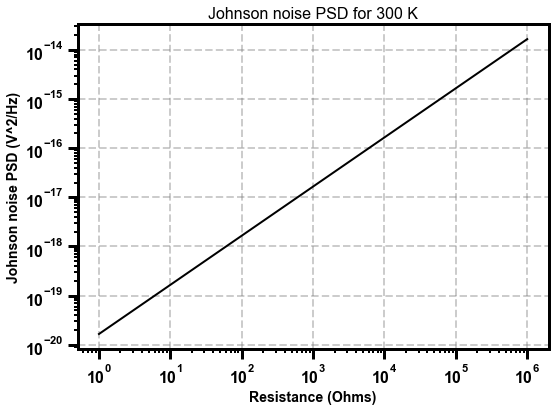

In [22]:
######################################################################################
def johnson_noise_psd(T, R):
    k = 1.38064852e-23 # Boltzmann constant in J/K
    return 4*k*T*R

fig, ax = plt.subplots(figsize=(8,6))
resistance = np.logspace(0, 6, 1000)
ax.loglog(resistance, johnson_noise_psd(300, resistance))
ax.set_xlabel("Resistance (Ohms)")
ax.set_ylabel("Johnson noise PSD (V^2/Hz)")
ax.set_title("Johnson noise PSD for 300 K")
ax.grid()
plt.tight_layout()
plt.show()

######################################################################################
def correlation_nik_vectorized(V1, V2):
    assert V1.size==V2.size
    n = V1.size
    lags = list(range(0,n,1))
    V2doubled = np.concatenate((V2,V2))
    cor = np.zeros(n)
    for lag in lags:
        cor[lag] = V1.dot(V2doubled[lag:lag+n])
    cor = cor/n
    return cor

# Testing Welch, Autocorrelation, and direct FFT algorithms to calculate PSD

Sampling frequency is 49999.99999999999 Hz
Et = 5826.651794236503 & Ek = 5826.900386700462


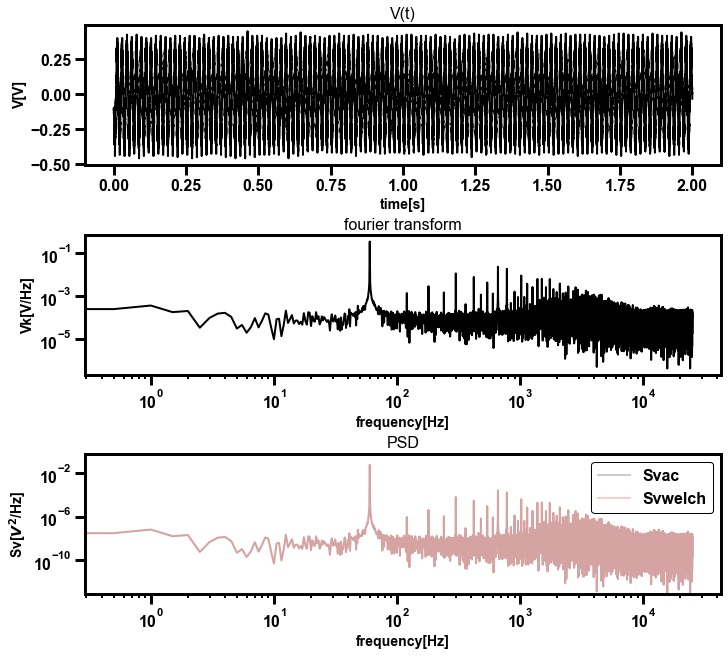

Svfft:
max=0.05727230722919241	min=8.997402458558348e-14
Svwelch:
max=0.057272307229192417	min=8.997402458556924e-14
Svac:
max=0.057272307229192396	min=8.997403718919586e-14
##################################################
sum of Svfft = 0.05826900386700462
sum of Svwelch = 0.05826403099367776
sum of Svac = 0.058269003867004565
Median noise between 1 KHz and 10 KHz is 2.561241864969118e-09 V^2/Hz


In [6]:

#######################Simulated signal#######################################
dt = 0.0001 # time step in s
T = 2 # total time in s
fs = int(1/dt) # sampling frequency in Hz
N = int(T/dt) #number of points
time = np.arange(0,T,dt) # time in seconds
# print(f"Sampling frequency is {1/dt} Hz")

fnoise_1 = 50 # noise frequency in Hz
Anoise_1 = 1 # noise amplitude

fnoise_2 = 120 # noise frequency in Hz
Anoise_2 = 0.7 # noise amplitude

V = Anoise_1*np.sin(2*np.pi* fnoise_1* time) + Anoise_2*np.sin(2*np.pi* fnoise_2* time)
######################################################################################
############### data from single acquisition##############################################
######################################################################################
# fp = "./data/data_1KOhm_single.csv"
fp="./data/scope_7_1.csv"# wire connected to the scope
# fp="./data/scope_13_1.csv"# 1 kOhm, time = 2 s, 100_000 samples
# fp="./data/scope_17_1.csv"# 15 kOhm, time = 0.1 s, 200_000 samples
# fp="./data/scope_18_1.csv"# 15 kOhm, time = 0.1 s, 200_000 samples
# fp="./data/scope_19_1.csv"# 1 kOhm, time = 0.1 s, 200_000 samples
# fp="./data/scope_20_1.csv"# 1 kOhm, time = 0.1 s, 200_000 samples
# fp="./data/scope_21_1.csv"# 100 kOhm, time = 0.1 s, 200_000 samples
# fp="./data/scope_22_1.csv"# 100 kOhm, time = 0.1 s, 200_000 samples
# fp="./data/scope_23_1.csv"# 100 kOhm, time = 0.1 s, 200_000 samples, bandpass filter, 1 KHz to 100 KHz
# fp="./data/scope_1.csv"# 100 KHz from function generator

df=pd.read_csv(fp,header=0,sep=",",skiprows=1, names=["time", "voltage"])
df.head()

T = df["time"].max()-df["time"].min() # seconds
N = df.shape[0]
fs = int(N/T) # Hz
dt = 1/fs
time = df["time"].to_numpy() - df["time"].min()
print(f"Sampling frequency is {1/dt} Hz")

V = df["voltage"].to_numpy()
#########################################################################################


#Discrete Fourier transform of V
Vk = np.absolute(fftshift(fft(V)))
Vk = 2*Vk[Vk.size//2:] # folding and only selecting positive frequencies
Vk = Vk/N # normalizing
fk = fftfreq(N,dt)
fk = fk[:fk.size//2]

# Energy calculation
Et = np.sum(np.absolute(V)**2)
Ek = np.sum(np.absolute(Vk)**2)*(N/2)

print(f"Et = {Et} & Ek = {Ek}")

#PSD from FFT
Svfft = (1/2)*np.absolute(Vk)**2

#PSD from welch
fwelch, Svwelch = welch(V, fs=fs, window='boxcar', nperseg=N, noverlap=0, return_onesided=True, scaling='density', axis=-1)
Svwelch = (1/2)*Svwelch

# PSD from autocorrelation
ac = correlation_nik_vectorized(V,V)
Svac = np.absolute(fftshift(fft(ac)))
Svac = Svac[Svac.size//2:]
Svac = Svac/fs

#plot
fig, (ax1,ax2, ax3) = plt.subplots(3,1, figsize=(10,9), constrained_layout=True)

ax1.plot(time, V)
ax1.set_xlabel("time[s]")
ax1.set_ylabel("V[V]")
ax1.set_title("V(t)")

ax2.plot(fk, Vk)
ax2.set_xlabel("frequency[Hz]")
ax2.set_ylabel("Vk[V/Hz]")
ax2.set_title("fourier transform")
ax2.set_xscale('log')
ax2.set_yscale('log')


# ax3.plot(fk, Svfft, alpha=0.8, label = "Svfft")
ax3.plot(fk, Svac, alpha=0.2, label = "Svac")
ax3.plot(fwelch, Svwelch, alpha=0.2, label = "Svwelch")
ax3.set_xlabel("frequency[Hz]")
ax3.set_ylabel("Sv[$V^2$/Hz]")
ax3.set_title("PSD")
ax3.set_ylim(Svwelch[10:].min()*0.9,Svwelch[10:].max()*10)
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.legend()

plt.show()

print(f"Svfft:\nmax={(Svfft.max())}\tmin={(Svfft[10:].min())}")
print(f"Svwelch:\nmax={(Svwelch.max())}\tmin={(Svwelch[10:].min())}")
print(f"Svac:\nmax={(Svac.max())}\tmin={(Svac[10:].min())}")
print(50*'#')
print(f"sum of Svfft = {np.sum(Svfft)}")
print(f"sum of Svwelch = {np.sum(Svwelch)}")
print(f"sum of Svac = {np.sum(Svac)}")

print(f"Median noise between 1 KHz and 10 KHz is {np.median(Svac[np.where((fk>5000) & (fk<90_000))])} V^2/Hz")

# Dataframe creation for plotting multiple waveforms together

In [ ]:
fps = ["./data/scope_19_1.csv", "./data/scope_17_1.csv", "./data/scope_21_1.csv"]
dfs = []
for fp in fps:
    df=pd.read_csv(fp,header=0,sep=",",skiprows=1, names=["time", "voltage"], index_col=0)
    dfs.append(df)

df_merged = pd.concat(dfs, ignore_index=True, axis=1)
df_merged.columns = [1, 2, 3]
df_merged.head()
df_merged.reset_index(inplace=True)
df_merged.head()

# Noise analysis using Welch for multiple files

300Ohm_100avg_100kpoints_gain5000_normal = 1.421443580199186e-09 between 3000 and 6000 Hz
1kOhm_100avg_100kpoints_gain5000_normal = 2.0263471902736035e-09 between 3000 and 6000 Hz
5kOhm_100avg_100kpoints_gain5000_normal = 3.3920352813702853e-09 between 3000 and 6000 Hz
20kOhm_100avg_100kpoints_gain5000_normal = 5.655610541751654e-09 between 3000 and 6000 Hz
35kOhm_100avg_100kpoints_gain5000_normal = 8.472653162622217e-09 between 3000 and 6000 Hz
50kOhm_100avg_100kpoints_gain5000_normal = 1.0925053624557299e-08 between 3000 and 6000 Hz


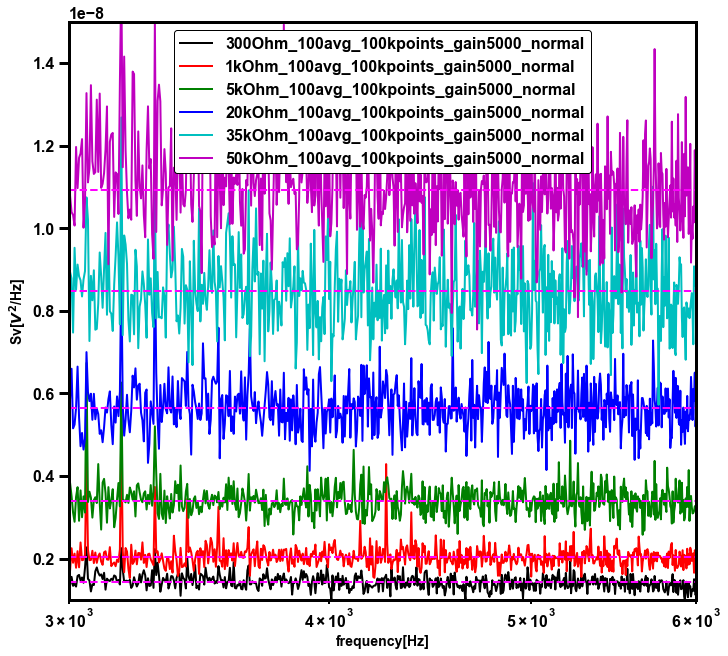

In [61]:
files = ['./data/johnson_data/scope_with_50Ohmterminator.csv',
         './data/johnson_data/50_Ohm_gain2000.csv']
files = ['./data/johnson_data/new_box_bg.csv', './data/johnson_data/new_box_500kOhm.csv']
files = ['./data/johnson_data/new_box_bg_improved.csv', 
            './data/johnson_data/new_box_250kOhm.csv',
         './data/johnson_data/new_box_500kOhm_improved.csv']
files = ["./data/RigolDHO1102/500kohmbg0.csv", 
         "./data/RigolDHO1102/500kohm2.csv", 
         "./data/RigolDHO1102/RigolDS2.csv"]
files = ["./data/RigolDHO1102/50Ohm_25avg.csv",
         './data/johnson_data/50_Ohm_terminator_scope_ch1_1.csv'] #Rigol vs Keysight scope
files = ['./data/RigolDHO1102/Pot_min_100avg.csv',
         "./data/RigolDHO1102/500KOhm_100avg.csv"] #Rigol 500kOhm vs 50 Ohm

files = ['data/johnson_data/using_rigol/Pot_min_100avg_100kpoints_gain5000_normal.csv',
         'data/johnson_data/using_rigol/5KOhm_100avg_100kpoints_gain5000_normal.csv',
         'data/johnson_data/using_rigol/500KOhm_100avg_100kpoints_gain5000_normal.csv'
         ]
# files = ['data/johnson_data/using_rigol/Pot_min_100avg_100kpoints_gain5000_normal.csv',
#          'data/johnson_data/using_rigol/5KOhm_100avg_100kpoints_gain5000_normal.csv'
#          ]
files = ['data/johnson_data/300Ohm_100avg_100kpoints_gain5000_normal.csv',
         'data/johnson_data/1kOhm_100avg_100kpoints_gain5000_normal.csv',
         'data/johnson_data/5kOhm_100avg_100kpoints_gain5000_normal.csv',
         'data/johnson_data/20kOhm_100avg_100kpoints_gain5000_normal.csv',
         'data/johnson_data/35kOhm_100avg_100kpoints_gain5000_normal.csv',
         'data/johnson_data/50kOhm_100avg_100kpoints_gain5000_normal.csv']
         
#10 kHz hi pass filter

fig, ax = plt.subplots(figsize=(10,9), constrained_layout=True)


for fp in files:
    df=pd.read_csv(fp,header=None,sep=",")
    df.rename(columns={0:"time"}, inplace=True)

    # if oscilloscope == "Rigol":
    #     df=pd.read_csv(fp,header=0,sep=",")
    #     df.rename(columns={0:"time", "CH1V" : 1}, inplace=True)
    #     dt = float(df.columns[2].split("=")[1].split("s")[0]) #time per point in ms
    #     dt = dt*1e-3 # the factor of 1e-3 is to convert ms to s
    #     df["time"] = np.arange(0,df.shape[0]*dt,dt)
    #     df.drop(columns=df.columns[1:4], inplace=True)

    ############################Time axis#######################################
    T = df["time"].max()-df["time"].min() # seconds
    N = df.shape[0]
    fs = int(N/T) # Hz
    dt = 1/fs
    time = df["time"].to_numpy() - df["time"].min()
    # print(f"Sampling frequency is {1/dt} Hz")

    # Sv_list = np.zeros((df.shape[0]//2, df.shape[1]-1)) # for autocorrelation
    Sv_list = np.zeros((df.shape[0]//2 + 1, df.shape[1]-1)) # for welch

    for i in range(1,df.shape[1]):
        V = df[i].to_numpy()
        V = V-V.mean()
        # print(f"calculating Sv for {i}th acquisition")
        ################PSD from autocorrelation####################################
        # ac = correlation_nik_vectorized(V,V)
        # Sv = np.absolute(fftshift(fft(ac)))
        # Sv = Sv[Sv.size//2:]
        # Sv = Sv/fs
        # Sv_list[:,i-1] = Sv
        ################PSD from welch##############################################
        fwelch, Svwelch = welch(V, 
                                fs=fs, 
                                window='boxcar', 
                                nperseg=N, 
                                nfft=N, 
                                return_onesided=True, 
                                scaling='density', 
                                axis=-1)
        Svwelch = (1/2)*Svwelch
        Sv_list[:,i-1] = Svwelch

    Sv_mean = np.mean(Sv_list, axis=1)
    label = f"{fp.split('/')[-1].split('.')[0]}"
    f_lo = 3_000 # Hz
    f_hi = 6_000 # Hz
    ################## frequency axis##############################################
    # fwelch = fftfreq(N,dt)
    # fwelch = fwelch[:fwelch.size//2]
    print(f"{label} = {np.median(Sv_mean[np.where((fwelch>f_lo) & (fwelch<f_hi))])} between {f_lo} and {f_hi} Hz")
    ax.plot(fwelch, Sv_mean, alpha=1, label = label)
    ax.axhline(np.median(Sv_mean[np.where((fwelch>f_lo) & (fwelch<f_hi))]), color='magenta', linestyle='--')
ax.set_xlabel("frequency[Hz]")
ax.set_ylabel("Sv[$V^2$/Hz]")
ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_ylim(1e-9,3e-8)
# ax.set_xlim(1e0,fwelch.max())
ax.set_ylim(1e-9,1.5e-8)
ax.set_xlim(f_lo,f_hi)
ax.axvline(f_hi, color='g', linestyle='--')
ax.axvline(f_lo, color='g', linestyle='--')
# ax.axhline(johnson_noise_psd(300,500_000), color='r', linestyle='--', label="Johnson noise")
ax.legend()
plt.show()

## Estimating kB

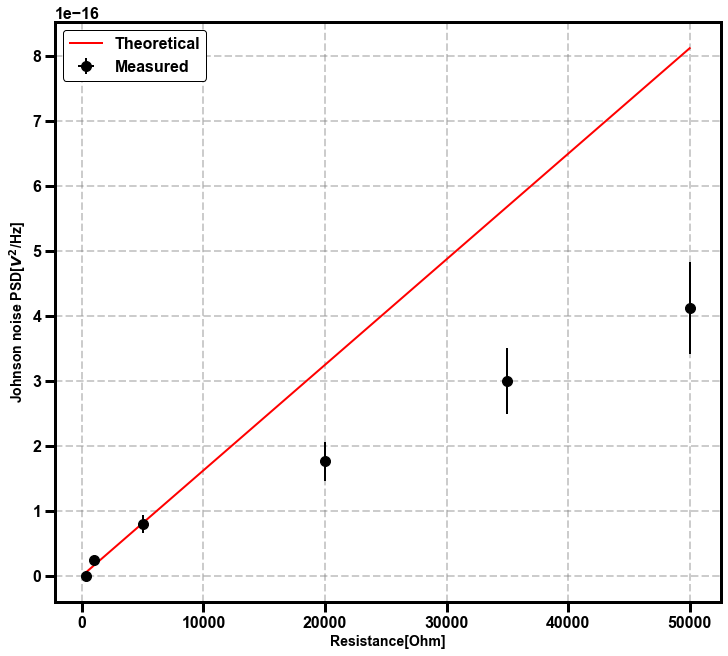

In [62]:
# S_meas = {
#     300 : 1.3687954814722911e-09,
#     1_000 : 2.0099483539817815e-09,
#     5_000 : 3.356518253632447e-09,
#     20_000 : 5.631602959258866e-09,
#     35_000 : 8.202848249129805e-09,
#     50_000 : 1.0260956906730618e-08
# } # Band width 5 KHz to 10 KHz

S_meas = {
    300 : 1.421443580199186e-09,
    1_000 : 2.0263471902736035e-09,
    5_000 : 3.3920352813702853e-09,
    20_000 : 5.655610541751654e-09,
    35_000 : 8.472653162622217e-09,
    50_000 : 1.0925053624557299e-08
} # Band width 3 KHz to 6 KHz

S_err = 0.05 # 5% error in PSD

# gain_meas = {
#     300 : 5000,
#     1_000 : 5000,
#     5_000 : 4949,
#     20_000 : 3700,
#     35_000 : 3600,
#     50_000 : 3500
# }

gain_meas = {
    300 : 5000,
    1_000 : 5000,
    5_000 : 4949,
    20_000 : 4900,
    35_000 : 4850,
    50_000 : 4800
}
gain_err = 0.05 # 5% error in gain

R_err = {
    300 : 5,
    1_000 : 100,
    5_000 : 100,
    20_000 : 100,
    35_000 : 100,
    50_000 : 100
}

S_bg = S_meas[300]

S_johnson = {}
for key in S_meas.keys():
    S_johnson[key] = (S_meas[key] - S_bg)/gain_meas[key]**2



fig, ax = plt.subplots(figsize=(10,9), constrained_layout=True)
ax.errorbar(x=list(S_johnson.keys()), 
            y=list(S_johnson.values()),
            yerr=[(2*gain_err + np.sqrt(2)*S_err)*s for s in list(S_johnson.values())], 
            xerr=list(R_err.values()),
            fmt='o', label="Measured")
ax.plot(list(S_johnson.keys()), [johnson_noise_psd(294,x) for x in list(S_johnson.keys())], '-', label="Theoretical")
ax.set_xlabel("Resistance[Ohm]")
ax.set_ylabel("Johnson noise PSD[$V^2$/Hz]")
ax.grid()
ax.legend()
plt.show()


# Cross correlation measurement

Sampling frequency is 500000.0 Hz
500KOhm_100avg = 1.0424492269636064e-14 between 20000 and 90000 Hz


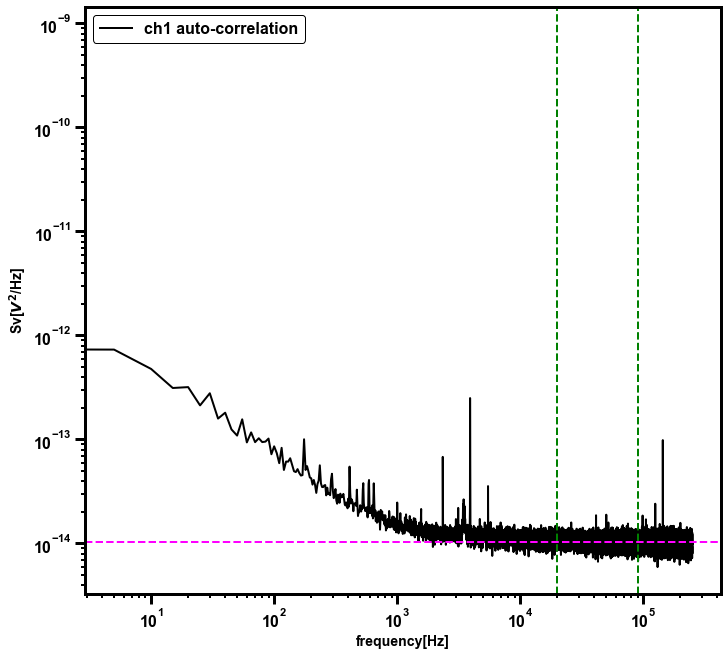

In [23]:
files = ['./data/RigolDHO1102/ch1_100avg_500KOhm.csv',
         "./data/RigolDHO1102/ch1_100avg_500KOhm.csv"]
         
fig, ax = plt.subplots(figsize=(10,9), constrained_layout=True)



df_1=pd.read_csv(files[0],header=None,sep=",")
df_1.rename(columns={0:"time"}, inplace=True)

df_2=pd.read_csv(files[1],header=None,sep=",")
df_2.rename(columns={0:"time"}, inplace=True)

############################Time axis#######################################
T = df_1["time"].max()-df_1["time"].min() # seconds
N = df_1.shape[0]
fs = int(N/T) # Hz
dt = 1/fs
time = df_1["time"].to_numpy() - df_1["time"].min()
print(f"Sampling frequency is {1/dt} Hz")
fwelch = fftfreq(N,dt)
fwelch = fwelch[:fwelch.size//2]

Sv_list = np.zeros((df_1.shape[0]//2, df_1.shape[1]-1)) # for crosscorrelation
for i in range(1,df_1.shape[1]):
    V1 = df_1[i].to_numpy()
    V2 = df_2[i].to_numpy()
    ###############PSD from cross-correlation####################################
    ac = correlation_nik_vectorized(V1,V2)
    Sv = np.absolute(fftshift(fft(ac)))
    Sv = Sv[Sv.size//2:]
    Sv = Sv/fs
    Sv_list[:,i-1] = Sv

Sv_mean = np.mean(Sv_list, axis=1)
f_lo = 20_000 # Hz
f_hi = 90_000 # Hz
print(f"{label} = {np.median(Sv_mean[np.where((fwelch>f_lo) & (fwelch<f_hi))])} between {f_lo} and {f_hi} Hz")
ax.plot(fwelch, Sv_mean, alpha=1, label = "ch1 auto-correlation")
ax.axhline(np.median(Sv_mean[np.where((fwelch>f_lo) & (fwelch<f_hi))]), color='magenta', linestyle='--')
ax.set_xlabel("frequency[Hz]")
ax.set_ylabel("Sv[$V^2$/Hz]")
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_ylim(1e-18,1e-9)
# ax.set_xlim(1e0,fwelch.max())
ax.axvline(f_hi, color='g', linestyle='--')
ax.axvline(f_lo, color='g', linestyle='--')
# ax.axhline(johnson_noise_psd(300,500_000), color='r', linestyle='--', label="Johnson noise")
ax.legend()
plt.show()

# Filter gain analysis

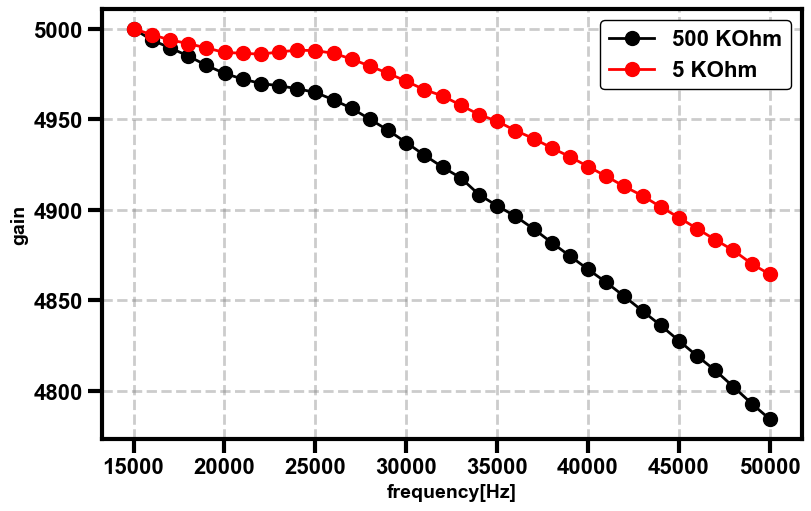

In [31]:
fp_500K = "data\gain analysis\gain_5000_500Kohm_10KHz_50kHz_LIA_10mV_100div.txt"
df_500K = pd.read_csv(fp_500K,
                 header=None, 
                 names=["frequency", "voltage"],
                 delimiter='\t')

df_500K["gain"] = 5e3*df_500K["voltage"]/df_500K.iloc[0]["voltage"]

fp_5K = "data\gain analysis\gain_5000_5000ohm_10KHz_50kHz_LIA_10mV_100div.txt"
df_5K = pd.read_csv(fp_5K,
                 header=None, 
                 names=["frequency", "voltage"],
                 delimiter='\t')

df_5K["gain"] = 5e3*df_5K["voltage"]/df_5K.iloc[0]["voltage"]

fig, ax = plt.subplots(figsize=(8,5), constrained_layout=True)
ax.plot(df_500K["frequency"], df_500K["gain"], 'o-', label="500 KOhm")
ax.plot(df_5K["frequency"], df_5K["gain"], 'o-', label="5 KOhm")
ax.set_xlabel("frequency[Hz]")
ax.set_ylabel("gain")
# ax.set_yscale('log')
ax.grid(which='both', axis='both')
ax.legend()
plt.show()

In [41]:
G_squared = (trapezoid(y=df_500K["gain"]**2,
          x=df_500K["frequency"]))/(df_500K["frequency"].max()-df_500K["frequency"].min())
print(f"G_squared = {G_squared}")
print(f"G = {np.sqrt(G_squared)}")

G_squared = 24110190.050267547
G = 4910.212831463372


In [43]:
G_squared = (trapezoid(y=df_5K["gain"]**2,
          x=df_5K["frequency"]))/(df_5K["frequency"].max()-df_5K["frequency"].min())
print(f"G_squared = {G_squared}")
print(f"G = {np.sqrt(G_squared)}")

G_squared = 24501195.721977912
G = 4949.868252991983


In [46]:
(3.48-1.59)/2.45

0.7714285714285714